In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

import time

$k$-means is a mathematically straightforward but computationally intensive hard-clustering method for grouping data into clusters of similar data points with similar variances.  It uses a cost function called the *inertia*, and the algorithm tries to choose means (called *centroids*) that minimize the inertia.  If you recall the lesson on linear regression, the formula for inertia may be familiar:

$$\sum(\bar{x}_c - x_i)^2$$

In words, the inertia is the sum of the squared differences between the centroid of a cluster (the mean $\bar{x}_c$) and the data points in the cluster ($x_i$).  The goal is to define cluster means so that the distance between a cluster mean and all the data points within the cluster is as small as possible.

So the *means* in $k$-means refers to the centroids.  The $k$ is the number of centroids (and thus, the number of clusters) the algorithm works with, which is provided by the user.  It's a pretty literal name.

How do you pick $k$?  Basically through trial and error.   Pick a $k$, look at the solution, see if it makes sense, then try other $k$'s.  Clusters representing "real" divisions in the data will be stable across training set and test set.

## How the algorithm works

$k$-means is an iterative algorithm that eventually converges on a solution.  It begins by choosing $k$ centroids at random, then repeats the following two steps until convergence:

1. Assign each data point to the nearest centroid
2. Create new centroids by taking the mean of all the data points assigned to each centroid

The algorithm stops when the difference between the old and new centroids is lower than a given threshold.

Like other iterative algorithms with a random start, bad starting centroid values can cause $k$-means to arrive at a lousy solution.  As a result, it is recommended to try the algorithm a few times with different starting centroids.  The sklearn implementation has a nifty `kmeans++` option for initializing centroids that are distant from each other, which is less likely to end in a flawed solution.


## Assumptions made by $k$-means models

$k$-means assumes that the underlying "true" clusters are radially symmetrical (isotropic), meaning that they are uniform in all directions and the edges curve outward.  It also assumes all clusters have similar variances.  See these [pictures of clusters](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py) that do and do not fit the $k$-means isotropic and variance assumptions.  

## Speed

High-dimensional data tends to make $k$-means run more slowly because it is more computationally demanding to measure the distance between each data point and the mean in a higher-dimensional space. A common practice is to run a PCA on the data first to reduce dimensionality, and then search for clusters in the reduced data.

If you don't want to reduce dimensions but you do have limited computational power or time, a different option is MiniBatchKMeans in sklearn, which randomly samples subsets of the training data in each iteration.  The loop steps are similar to those in the original:

 1. Assign the samples to their nearest centroids.
 2. Update the centroids based on the streaming average of all of the samples that have been assigned to the centroid so far.

The solution you get will be a little worse than regular $k$-means but drastically faster.

## Applying the model

Let's try $k$-means on some [heart disease data](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UC Irvine Machine Learning Repository.  Our goal will be to create a $k$-means solution that correctly assigns patients to "heart disease diagnosis" or "no heart disease diagnosis" clusters.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", header=None, error_bad_lines=False)

# Define the features and the outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

To make it easier to visualize our potential clusters, we will reduce the data to 2 components using PCA.

Time taken: 0.025 seconds.


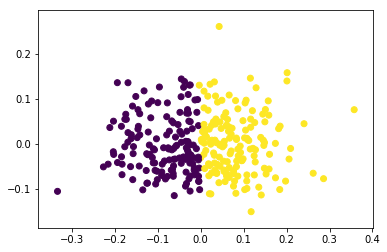

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      84  65
1      55  99


In [3]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
start_time=time.time()
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)
print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Looks like this model isn't doing very well. We're correctly classifying 182 cases, but mis-classifying 120 of the cases!

Now let's try MiniBatch:

In [4]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
start_time=time.time()

minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)
print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
print('Minibatch result:\n',pd.crosstab(predict_mini, y))

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

Time taken: 0.012 seconds.
Minibatch result:
 col_0   0    1
row_0         
0      57  104
1      82   60
Comparing k-means and mini batch k-means solutions:
col_0    0    1
row_0          
0        8  153
1      141    1


This marks a significant change. How substantial is the computational performance improvement? Try re-running the $k$-means and mini batch $k$-means models and timing their execution. Check out the [%timeit magic](https://ipython.org/ipython-doc/3/interactive/magics.html#magic-timeit) for helpful timing tools.<br>
<br>
NR:Minibatch is almost 3 times faster than sklearn's Kmeans.

## Drill: More clusters?

Your task is to take the $k$-means code here and see what happens when you change the value of $k$.  What solution, if any, do you find most compelling? Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor.  Keep in mind that it may be possible to have a solution with more than two clusters that is still better at tracking the real binary outcome – two of those clusters may map to "heart disease" while the other maps to "no heart disease," for example.

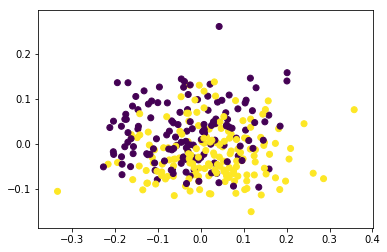

In [5]:
# How does the classifiation actually look?
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.show()

In [6]:
# The data almost completly overlaps.

In [7]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.

In [11]:
def runKMeans(X_pca,y,K):
    print('KMeans')
    start_time=time.time()
    y_pred = KMeans(n_clusters=K, random_state=42).fit_predict(X_pca)
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))

    # Plot the solution.
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
    plt.show()

    # Check the solution against the data.
    print('Comparing k-means clusters against the data:')
    print(pd.crosstab(y_pred, y))
    return(y_pred)

In [12]:
def RunMiniBatchKmeans(X_pca,y,K):
    print()
    print('MiniBatch')
    minibatchkmeans = MiniBatchKMeans(
        init='random',
        n_clusters=K,
        batch_size=200)
    start_time=time.time()

    minibatchkmeans.fit(X_pca)

    # Add the new predicted cluster memberships to the data frame.
    predict_mini = minibatchkmeans.predict(X_pca)
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    
    # Plot the solution.
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict_mini)
    plt.show()
    
    df=pd.crosstab(predict_mini, y)
    
    print('Comparing Minibatch against the data:\n',pd.crosstab(predict_mini, y))
    return(predict_mini)

KMeans
Time taken: 0.048 seconds.


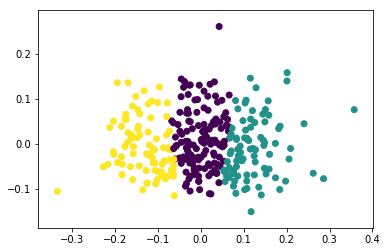

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      65  70
1      25  61
2      49  33

MiniBatch
Time taken: 0.015 seconds.


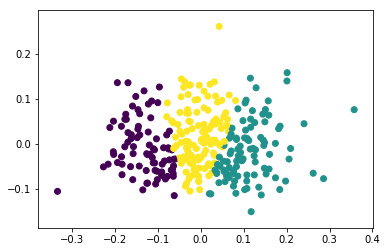

Comparing Minibatch against the data:
 col_0   0   1
row_0        
0      48  33
1      28  69
2      63  62

Comparing k-means and mini batch k-means solutions:
col_0   0   1    2
row_0             
0       1  12  122
1       0  85    1
2      80   0    2


In [13]:
K=3
KMpredict=runKMeans(X_pca,y, K)
Minipredict=RunMiniBatchKmeans(X_pca,y,K)

# Check the MiniBatch model against our earlier one.
print('\nComparing k-means and mini batch k-means solutions:')
print(pd.crosstab(KMpredict, Minipredict))

KMeans
Time taken: 0.084 seconds.


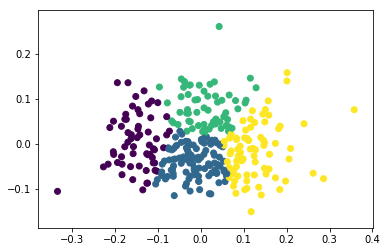

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      40  21
1      37  67
2      42  20
3      20  56

MiniBatch
Time taken: 0.022 seconds.


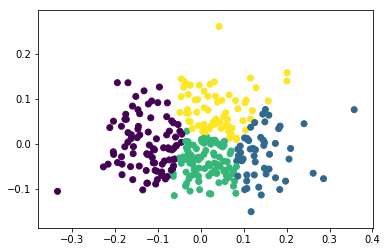

Comparing Minibatch against the data:
 col_0   0   1
row_0        
0      55  35
1      12  40
2      31  63
3      41  26

Comparing k-means and mini batch k-means solutions:
col_0   0   1   2   3
row_0                
0      61   0   0   0
1      24   0  80   0
2       5   0   1  56
3       0  52  13  11


In [14]:
K=4
KMpredict=runKMeans(X_pca,y, K)
Minipredict=RunMiniBatchKmeans(X_pca,y,K)

# Check the MiniBatch model against our earlier one.
print('\nComparing k-means and mini batch k-means solutions:')
print(pd.crosstab(KMpredict, Minipredict))

KMeans
Time taken: 0.052 seconds.


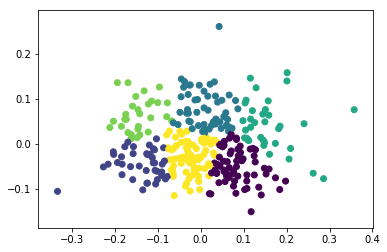

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      14  52
1      20  21
2      34  20
3      14  21
4      23   6
5      34  44

MiniBatch
Time taken: 0.021 seconds.


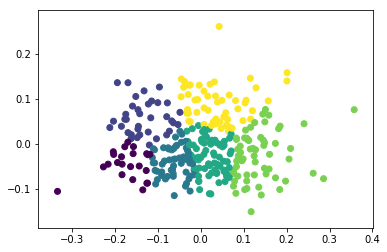

Comparing Minibatch against the data:
 col_0   0   1
row_0        
0      14   9
1      29   7
2      25  31
3      22  50
4      15  46
5      34  21

Comparing k-means and mini batch k-means solutions:
col_0   0   1   2   3   4   5
row_0                        
0       0   0   0  30  36   0
1      23   2  16   0   0   0
2       0   3   0   6   0  45
3       0   0   0   0  25  10
4       0  29   0   0   0   0
5       0   2  40  36   0   0


In [15]:
K=6
KMpredict=runKMeans(X_pca,y, K)
Minipredict=RunMiniBatchKmeans(X_pca,y,K)

# Check the MiniBatch model against our earlier one.
print('\nComparing k-means and mini batch k-means solutions:')
print(pd.crosstab(KMpredict, Minipredict))

KMeans
Time taken: 0.121 seconds.


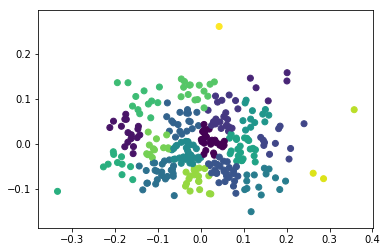

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0       9  15
1      14   3
2       4   1
3      15   7
4       2   9
5       6  22
6      11   8
7       7  17
8       2  12
9      17  13
10      7   5
11      6  17
12      7   4
13     11   1
14      8   7
15      7   6
16      5  14
17      0   1
18      0   2
19      1   0

MiniBatch
Time taken: 0.028 seconds.


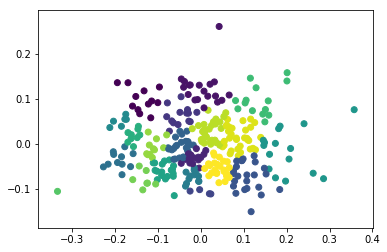

Comparing Minibatch against the data:
 col_0   0   1
row_0        
0      11   1
1      12   7
2       6   9
3       8   6
4       0   4
5       3  21
6      15   9
7       9   2
8       5   7
9       6   0
10      3  13
11      7  11
12      6   3
13     10   4
14      0   1
15      0   7
16      6   5
17     14  15
18     13  19
19      5  20

Comparing k-means and mini batch k-means solutions:
col_0  0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
row_0                                                                           
0       0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0  17   
1       0   0   0   0   0   0   0   2   0   6   0   0   9   0   0   0   0   0   
2       0   0   0   0   0   0   0   0   0   0   0   0   0   5   0   0   0   0   
3       0   4   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0  10   
4       0   0   0   0   0   0   0   0   0   0  10   0   0   0   0   0   0   0   
5       0   0   0   0   0   7   0

In [16]:
K=20
KMpredict=runKMeans(X_pca,y, K)
Minipredict=RunMiniBatchKmeans(X_pca,y,K)

# Check the MiniBatch model against our earlier one.
print('\nComparing k-means and mini batch k-means solutions:')
print(pd.crosstab(KMpredict, Minipredict))

## My observations

The real clusters overlap a lot.
When using the same number of clusters, the results between KMeans and MiniBatch don't very a lot.
I think the best classification is performed by 2, 4 and 6 clusters.
With an increasing number of clusters the classfication get's better and better, but that is overfitting. I don't think this is the right approach here.